In [31]:
from sktime.registry import all_estimators
import pandas as pd
from sktime.datasets import load_airline
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error, mean_squared_percentage_error, mean_squared_error
from sktime.utils.plotting import plot_series
from sktime.forecasting.fbprophet import Prophet

from matplotlib import pyplot as plt
import seaborn as sns
import sktime

# Time Series Forecasting

We can revisit time series forecasting breifly and look at a few techniques to generate forecasts. 

### Components of Time Series

We can break down a time series into components:
<ul>
<li> Trend - the overall direction of the series. 
<li> Seasonality - the periodicity of the series. 
<li> Noise/Irregularity - the random variation of the series.
<li> Cyclic - the non-periodic variation of the series.
</ul>

![Time Series Parts](images/time_series_parts.jpg "Time Series Parts")

These all impact forecasting when dealing with time series data. We need to know the general trend, are we going up or down? We need to know about seasonality, is there a pattern that repeats itself? We need to know about noise, is there a lot of random variation? We need to know about cyclic, is there a pattern that repeats itself but not on a regular basis? All of the time series techniques below are variations of extracting these components to make reliable predictions. We won't go extremely deep into time series forecasting, it is a large topic and has quite a few differences from the other work that we are doing. The aim here is to give an overview of some of the tools we can use to approach time series data, and build a bit of a foundation for further exploration should you encounter these challenges. 

## Time Series Forecasting with SKtime

SKtime provides a familiar interface to time series functionality. 

### Common Lingo

<ul>
<li> forecaster = model
<li> ForecasterHorizon = what to create predictions for
</ul>

#### Load Airline Data

Our ariline data here measures the number of passengers per month from 1949 to 1960. We will use this data to predict the number of passengers looking forward. 

(<Figure size 1600x400 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

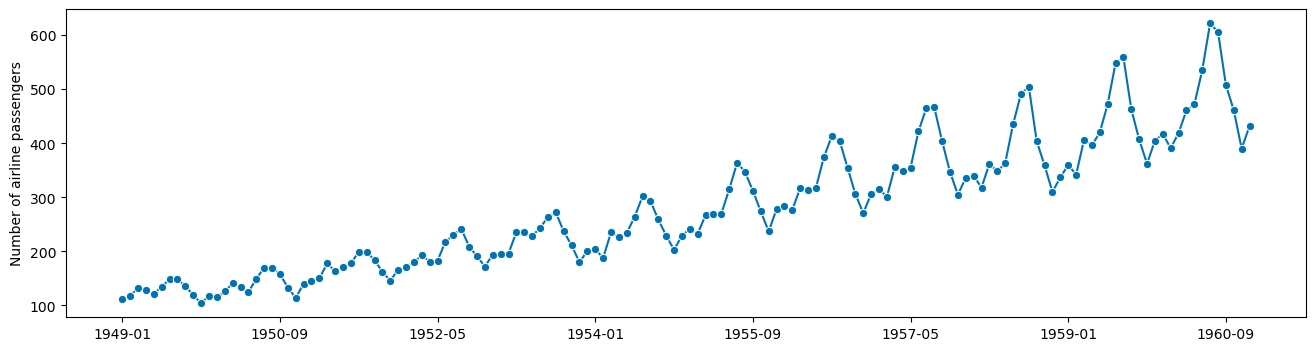

In [32]:
y = load_airline()
plot_series(y)

## Train-Test Split

Since time series runs sequentially, the train-test split for error calcualtions is normally just chopping off the last part of the sequence and use that to test. Sktime provides a dedicated function to do so. You'll commonly see array notation to slice before/after as well. 

Here we take the final 36 months for testing. We also make a forecast horizion, this one is set to be the months of the test data, since we are evaluating accuracy. 

In [33]:
y_train, y_test = temporal_train_test_split(y, test_size=36)
fh = ForecastingHorizon(y_test.index, is_relative=False)

## Exponential Smoothing. 

We can guess that the period is 12 months since it looks like a yearly pattern. We can also try the trend being additive and the seasonality being multiplicitive. We looked at exponential smoothing a little bit back in stats when we introduced residuals and error. In short, the exponential smoothing model is a smarter weighted average, with some wrinkles to account for trend and seasonality. These exponential smoothing models are a good starting point, and probably the most simple type of forecasting we can perform. 

### Additive or Multiplicitive

One thing we need to consider is if the trend and seasonality are additive or multiplicitive, or how it changes over time. Additive means that the trend and seasonality are added to the base value, multiplicitive means that the trend and seasonality are multiplied by the base value. This difference is important because it changes how we calculate the forecast, it is probably more easy to understand by looking at it visually. Rule of thumb: if the difference is changing over time -> multiplicitive, if it is constant -> additive. 

![Additive or Multiplicitive](images/add_mult.gif "Additive or Multiplicitive")

Here the size of the seasonal swings seems to be getting larger, so that is multiplicitive. The trend seems to be a constant increase, so additive. We can see how to test these later - it is not always obvious. 

For the trend we have the same question, is it additive or multiplicitive? We can see that the trend is increasing at a linear looking rate, so it is probably additive. Multiplicitive trends would follow the same pattern, the rate of increase would be increasing, so we'd see a general curve to the data. 

These factors act to "account for" the trend and seasonality swings in our data, effectively adapting the weighting of values used in the weighted average to capture both the general increase in value from the trend, and the up and down swings from the seasonality.

In [34]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.compose import TransformedTargetForecaster

0.0034776210373196137

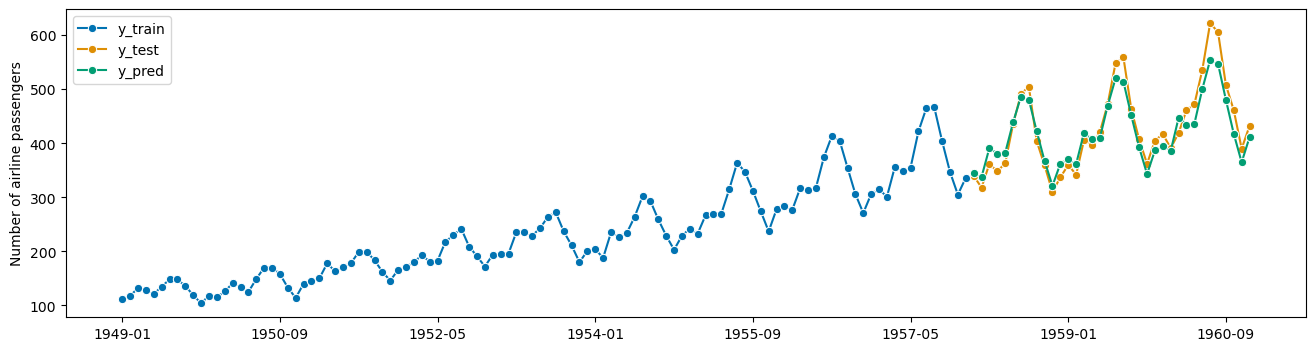

In [35]:
forecaster = ExponentialSmoothing(trend="add", seasonal="mul", sp=12)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_squared_percentage_error(y_pred, y_test)

Results - it looks like our model was pretty good. What if we want to make predictions into the future? We need to modify the forecasting horizion to, well, look into the horizon, then it is pretty similar. We can give the month indicies for the future months, as well as an argument "is_relative" that will tell sktiem to pick up at the end. 

We can also retrain the model to use all the data, since we are done evaluating the model here. 

(<Figure size 1600x400 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

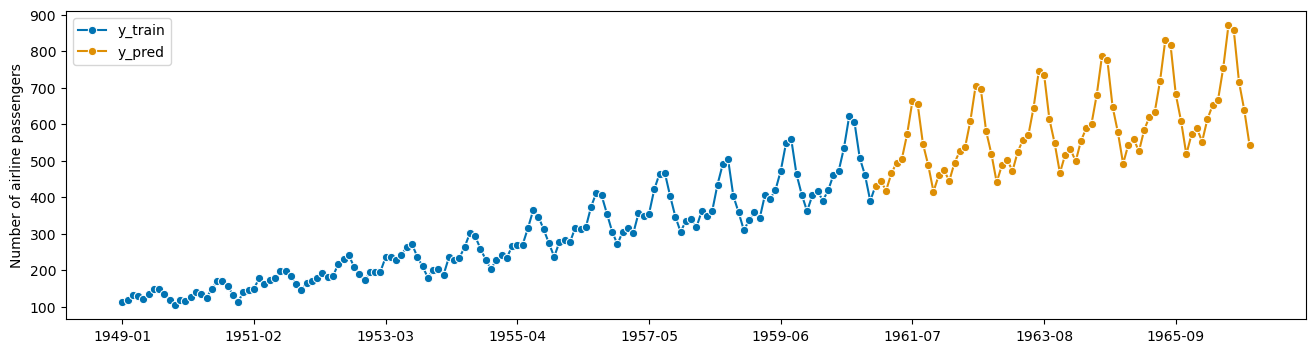

In [36]:
# Next 6 years
dates_range = list(range(0, 72))
fh_long = ForecastingHorizon(values=dates_range, is_relative=True)
forecaster.fit(y)
y_pred = forecaster.predict(fh_long)
plot_series(y, y_pred, labels=["y_train", "y_pred"])

## AutoRegressive Integrated Moving Average - ARIMA

<b>Note: we will largely deemphasize the process for finding the optimal parameters for the model, as it is a bit involved, and not super relevant to the other work we'll be doing. This part is really more of an exploration, we can rely on the automated tools to find the optimal parameters for us.</b>

A famous and widely used forecasting method for time-series prediction is the AutoRegressive Integrated Moving Average (ARIMA) model. ARIMA models are capable of capturing a suite of different standard temporal structures in time-series data.

ARIMA relies on a few specific parts:
<ul>
<li> AR: < Auto Regressive > means that the model uses the dependent relationship between an observation and some predefined number of lagged observations (also known as “time lag” or “lag”).
<li> I:< Integrated > means that the model employs differencing of raw observations (e.g. it subtracts an observation from an observation at the previous time step) in order to make the time-series stationary.
<li> MA: < Moving Average > means that the model exploits the relationship between the residual error and the observations.
</ul>

There a few model parameters that we need to supply as well, the standard ARIMA models expect as input parameters 3 arguments i.e. p,d,q.
<ul>
<li> p is the number of lag observations.
<li> d is the degree of differencing.
<li> q is the size/width of the moving average window.
</ul>

We can try a similar approach to the predictions we made with exponential smoothing above with an ARIMA model. There is a more detailed explaination here, we don't need to get too bogged down in the details though: https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/ 

#### ARIMA from Scratch

The ARIMA model is a bit more complex than the exponential smoothing model, in particular this explortation for the optimal parameters is a bit more involved. Below, we have a bit more efficient method of finding the optimal parameters, and in practice we can rely on that (and similar approaches) to find the optimal parameters for a model. This next part if mostly for illustration purposes, but if it isn't super logical to you, we are safe to skip the details, as long as the concepts make sense. This parameter finding exercise is  kind of an odd process, so we don't want to get too bogged down in the details if they are not clear. 

In [37]:
from sktime.forecasting.arima import ARIMA

#### AD Fuller Test for D Term

Our first goal here is to make the time series "stationary", or remove the trend and seasonality. We can do this by differencing the data, or subtracting it from a previous value. The number of .diff()s in the code is the number of differences that we are introducing. We can use the Augmented Dickey-Fuller test to determine the number of differences we need to make the data stationary. The ADF test aims to reject the null hypothesis that the given time-series data is non-stationary. It calculates the p-value and compares it with a threshold value or significance level of 0.05. If the p-value is less than this level, then the data is stationary; else, the differencing order is incremented by one. Or in English, we are doing a hypothesis test of "is the data stationary", with a null hypothesis of "the data is non-stationary". If the p-value is less than 0.05, we have a good dataset, and we set the d value to this - the smallest number of diffs that makes the data stationary.

Visually, we want the data to be "flat" and not have a trend.

ADF Statistic: -2.829267
p-value: 0.054213


(<Figure size 1600x400 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

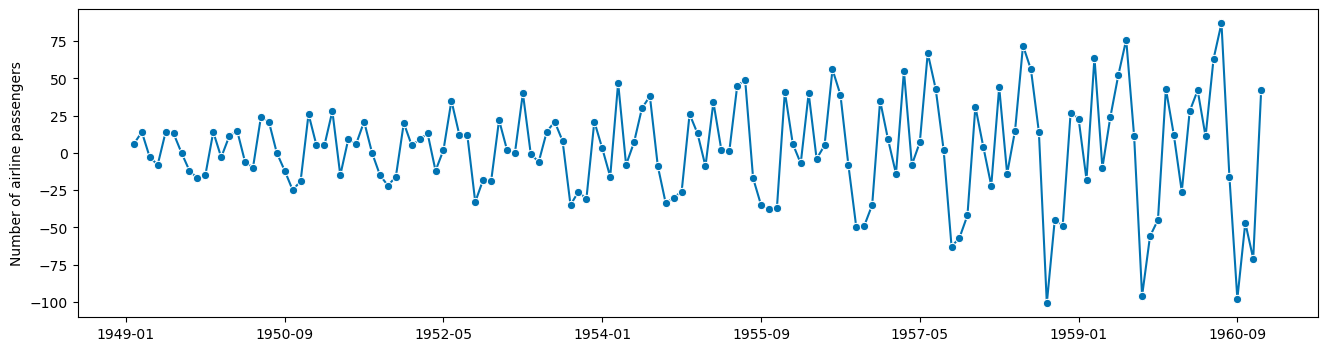

In [38]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(y.diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
plot_series(y.diff())

## Partial Autocorrelation and Partial Autocorrelation for MA and AR. 

Determining p and q is a little more haphazard. Below is a processes to look for them with the ACF and PACF charts. In short, we can look for a starting point, then potentially adjust. We will have a solution for this soon...

<b>Process:</b>
<ol>
<li>If the PACF of the differenced series shows a sharp cut off and/or the lag1 autocorrelation is positive (this indicates an ‘under- differenced’ series) while the ACF decays more slowly , then consider adding an AR term to the model. The number of AR terms will depend on the lag at which PACF cuts off.
<li>If the ACF of the differenced series shows a sharp cut off and/or the lag1 autocorrelation is negative (this indicates an ‘over- differenced’ series) while the PACF decays more slowly , then consider adding MA term to the model. Here, the autocorrelation pattern is explained more by adding the MA terms. The number of MA terms will depend on the lag at which ACF cuts off.
<li>An AR term is associated with under-differencing or positive auto correlation at lag 1while an MA term is associated with over-differencing or negative auto correlation at lag 1.
</ol>

In [39]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

c:\Users\Elsa\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


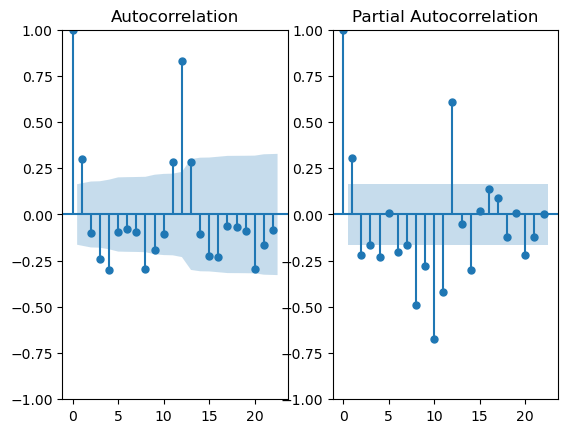

In [40]:
# ACF/PACF plot of 1st differenced series
fig, axes = plt.subplots(1, 2)
plot_acf(y.diff().dropna(), ax=axes[0])
plot_pacf(y.diff().dropna(), ax=axes[1])

plt.show()

We can try:
<ul>
<li> AR (p) - 1
<li> I (d) - 1
<li> MA (q) - 1
</ul>

### Seasonality

Seasonality - we can guess pretty easily that it is a one year pattern, so we can include that as m. The seasonal_order attributes are:

<ul>
<li> P: Seasonal autoregressive order
<li> D: Seasonal difference order
<li> Q: Seasonal moving average order
<li> m: The number of time steps for a single seasonal period
</ul>

This is basically a mini version of what we just did, and we supply these parameters in the seasonal_order parameter. 

#### Check D

AD Fuller test. p Value is small, no differencing needed. 

In [41]:
result = adfuller((y-y.shift(12)).dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -3.383021
p-value: 0.011551


#### Check P and Q

c:\Users\Elsa\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


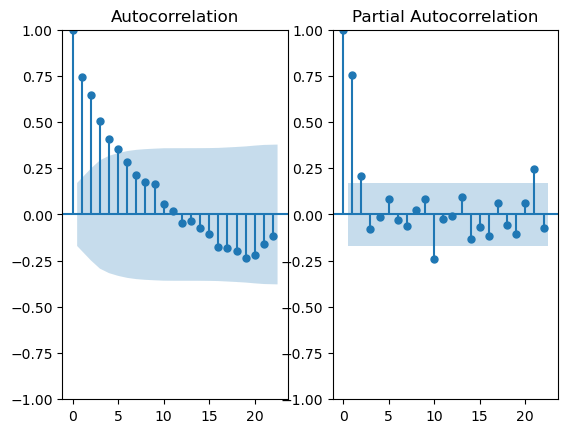

In [42]:
fig, axes = plt.subplots(1, 2)
plot_acf((y-y.shift(12)).dropna(), ax=axes[0])
plot_pacf((y-y.shift(12)).dropna(), ax=axes[1])
plt.show()

### Check Model Accuracy

We'll make a model with the parameters that we determined above, make some test predictions, and calculate the error.

0.002201108797525472

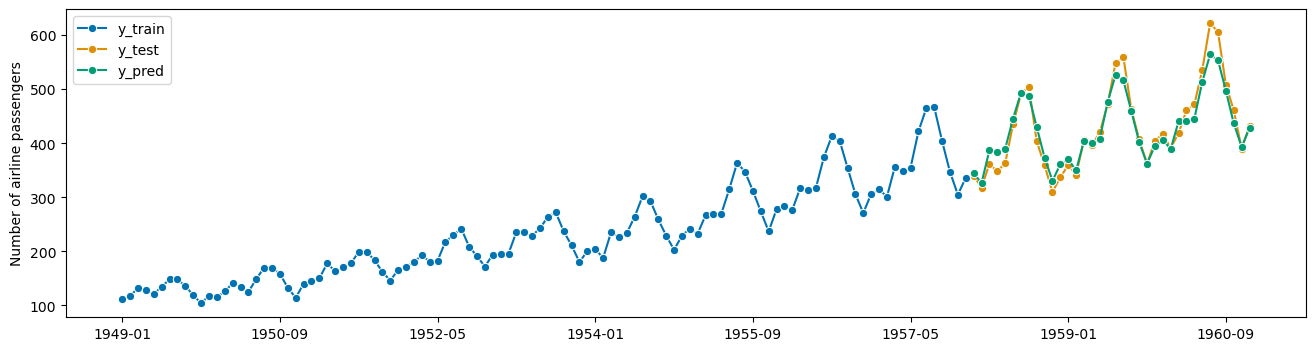

In [43]:
forecaster = ARIMA(order=(1, 1, 1), seasonal_order=(2, 0, 6, 12), suppress_warnings=True)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_squared_percentage_error(y_pred, y_test)

#### Predict Into Future

If we are happy with our model, we can retrain it on all the data and make predictions into the future.

(<Figure size 1600x400 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

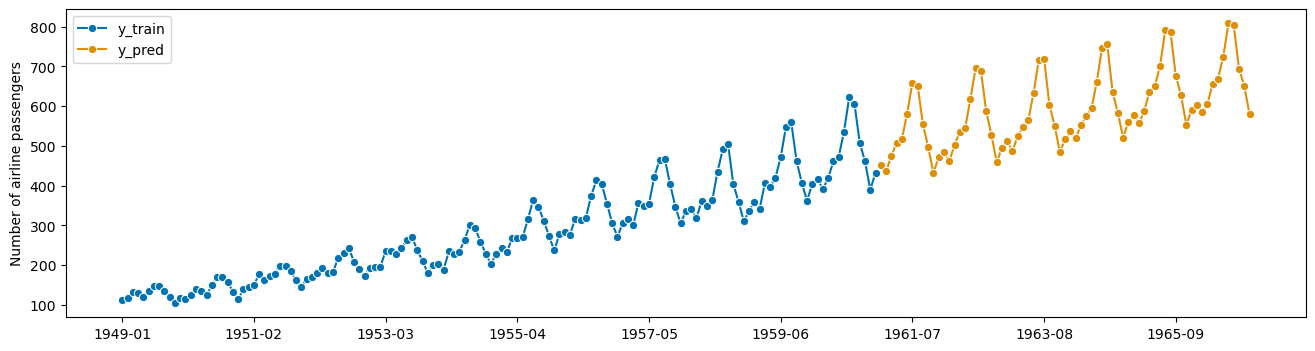

In [44]:
dates_range = list(range(0, 72))
fh_long = ForecastingHorizon(values=dates_range, is_relative=True)
forecaster.fit(y)
y_pred = forecaster.predict(fh_long)
plot_series(y, y_pred, labels=["y_train", "y_pred"])

## AutoARIMA

Going through all that work to find ARIMA terms seems suboptimal, and it is. We can use AutoARIMA to do a grid-search-ish process to find the ARIMA values for us. We supply the sp=12 for the seasonality pattern. Try without it, or with something different and observe. In practice, this is probably a better overall approch unless we are really trying to tailor a model in a very customized way. For us, we are happy with this, skipping the work we did above. 

In [45]:
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.arima import ARIMA

0.040936759320966694
{'ar.L1': -0.24111778986083574, 'sigma2': 92.74986459318954, 'order': (1, 1, 0), 'seasonal_order': (0, 1, 0, 12), 'aic': 704.0011679023804, 'aicc': 704.1316026849892, 'bic': 709.1089216855815, 'hqic': 706.0650836393819}


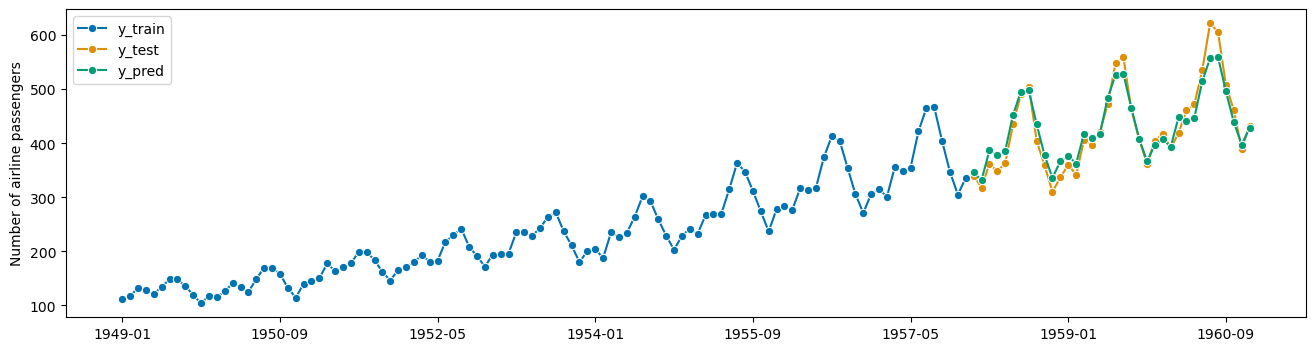

In [46]:
forecaster = AutoARIMA(sp=12, suppress_warnings=True)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
print(mean_absolute_percentage_error(y_pred, y_test))
print(forecaster.get_fitted_params())

## Simple Model Results

Above, all of the models are pretty similar, all of them generating pretty accurate predictions in our test data. This toy dataset is pretty easy to predict, the patterns in the data look quite uniform, so something like the simple exponential smoothing model is able to model it quite well. A pattern like this isn't uncommon for forecasting - we want to try models that are simple first, then look to make things more complex if we need to. Remember that we're literally making predictions in the future, which obviously has a lot of uncertainty - sometimes ingoring all of the other data that we may think is important and just using a simple model that extends the pattern is the best approach.

## Automated Tools and Pipelines

Since sktime is structured like sklearn, we can incorporate things into standard functionality like pipelines. The sktime library provides a TransformedTargetForecaster that we can use as a pipeline - the reason for this difference is because the time series data is the target data, not the feature set like a normal pipeline. 

There are also a few other automated tools that we won't explore in detail, but are clearly named and explained in the documentation:
<ul>
<li> Detrender - remove trends from time series. 
<li> Deseasonalizer - remove seasonality from time series. 
</ul>

Both transform the time series data to remove the non-stationary bits. 

In [47]:
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformations.series.detrend import Detrender
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.detrend import Deseasonalizer

0.06067370896958731

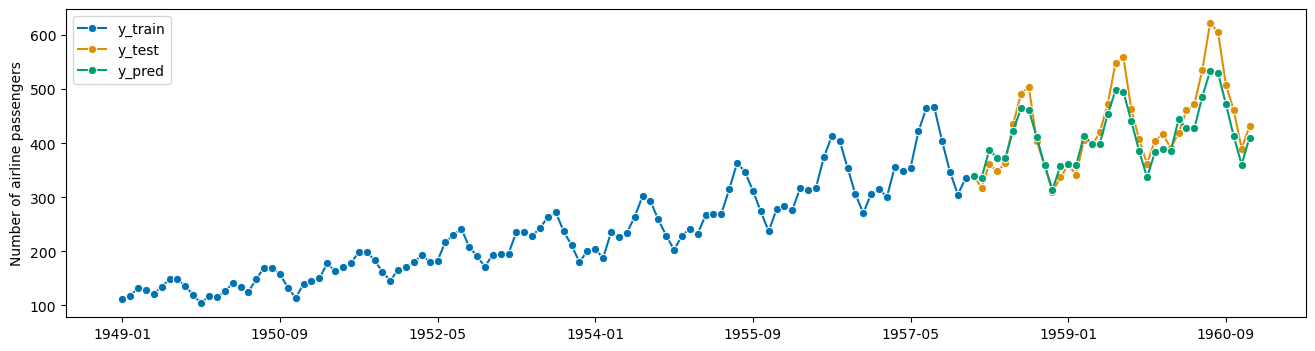

In [48]:
forecaster = TransformedTargetForecaster(
    [
        ("deseasonalize", Deseasonalizer(model="multiplicative", sp=12)),
        ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
        ("forecast", AutoARIMA()),
    ])

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_pred, y_test)

### GridSearch

We can also use a forecasting grid search to test for the best parameters, just like normal. The customizations here are:
<ul>
<li> The crossvalidation is provided by the SlidingWindowSplitter, which will slice a time series into windows for tests. 
<li> The OptionalPassthrough allows the True/False inclusion in the cv, so we can test if things should be included or not. 
</ul>

In [49]:
#!pip install pmdarima
#!pip install Prophet
#!pip install sktime[all_extras]

Looking in indexes: https://pypi.org/simple/
Looking in indexes: https://pypi.org/simple/
Looking in indexes: https://pypi.org/simple/


In [50]:
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.forecasting.model_selection import ForecastingGridSearchCV, SlidingWindowSplitter
from sktime.transformations.compose import OptionalPassthrough
from sktime.transformations.series.detrend import Deseasonalizer

In [51]:
# create pipeline
pipe = TransformedTargetForecaster(
    steps=[
        ("deseasonalizer", OptionalPassthrough(Deseasonalizer())),
        ("forecaster", ExponentialSmoothing()),
    ])

# putting it all together in a grid search
cv = SlidingWindowSplitter(initial_window=36, window_length=24, start_with_window=True, step_length=24)

param_grid = {
    "deseasonalizer__passthrough": [True, False],
    "forecaster__sp": [2,3,4,5,6,7,8,9,10,11,12],
    "forecaster__trend": ["add", "mul"],
    "forecaster__seasonal": ["add", "mul"]
}
gscv = ForecastingGridSearchCV(forecaster=pipe, param_grid=param_grid, cv=cv, n_jobs=-1)

0.0034776210373196137
{'deseasonalizer__passthrough': True, 'forecaster__seasonal': 'mul', 'forecaster__sp': 12, 'forecaster__trend': 'add'}


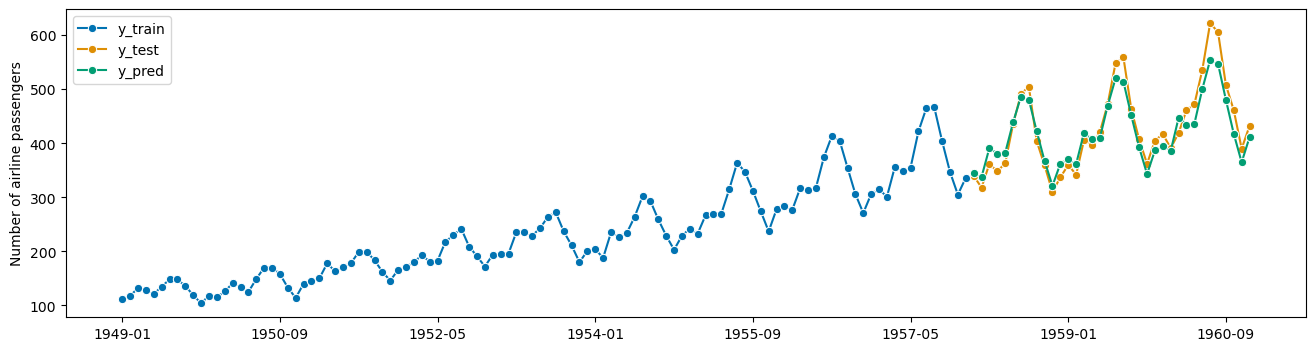

In [52]:
gscv.fit(y_train)
y_pred = gscv.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
print(mean_squared_percentage_error(y_pred, y_test))
print(gscv.best_params_)

## FaceBook Prophet, Part 1

One different thing that we can do with sktime is that we can import a pre-trained model and use it - in this case something offered by Facebook called Prophet. This package is a more sophisticated model for time series predictions created by Facebook. We can look to the documentation for details. We can use it's "smarts", supply some basic parameters based on our data, and get a model that is ready to go.

S<b>Note:</b> here we are using a sklearn wrapper on the the full FB Prophet package, which makes it simple to set things like the seasonality. Later when we add multiple regressors, we can use the normal Prophet package.

In [53]:
# Load the SKTime Prophet 
from sktime.forecasting.fbprophet import Prophet

In [54]:
# Convert index to pd.DatetimeIndex

z = y.copy()
z = z.to_timestamp(freq="M")
z_train, z_test = temporal_train_test_split(z, test_size=36)


forecaster = Prophet(
    seasonality_mode="multiplicative",
    n_changepoints=int(len(y_train) / 12),
    add_country_holidays={"country_name": "Canada"},
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
)

forecaster.fit(z_train)
y_pred = forecaster.predict(fh.to_relative(cutoff=y_train.index[-1]))
y_pred.index = y_test.index

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_squared_percentage_error(y_pred, y_test)

AttributeError: 'Prophet' object has no attribute 'stan_backend'

## Exercise - Predict Shampoo Sales in the Future

We'll load some data on shampoo sales, and try to predict the future. There are sections below from the sample solution, of a few different models. Try a couple if you have time, skip the manual ARIMA if you're going to skip anything. 

36


(<Figure size 1152x288 with 1 Axes>,
 <AxesSubplot:ylabel='Number of shampoo sales'>)

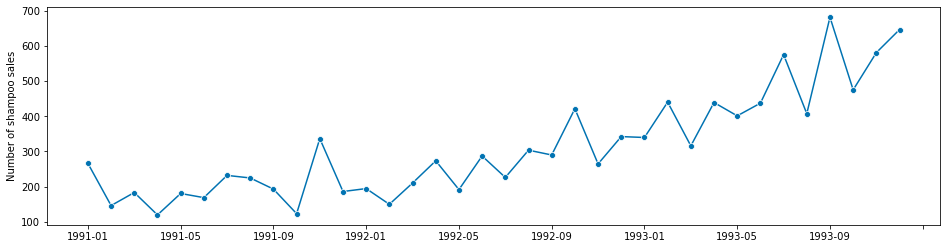

In [ ]:
from sktime.datasets import load_shampoo_sales
sh = load_shampoo_sales()
print(len(sh))
plot_series(sh)

#### Split

#### Exponential Smoothing

#### ARIMA

#### AutoARIMA

#### Predict Into Future

## Multiple Regressors and Facebook Prophet, Part 2

We can try to predict some stock prices, and use the full Prophet model to do so. One thing that we need to do a little differently is to prepare the data especially for Prophet. We are expected to have a dataframe with:
<ul>
<li> <b>ds</b> - the date column is labeled "ds".
<li> <b>y</b> - the target column is labeled "y".
<li> <b>Other Regressor</b> - any other columns that we want to use as regressors. These have no name rules. 
</ul>

We'll also use the Yahoo finance module to download some data on stock prices. 

Prophet has a bunch more options that we can configure, the documentation is https://facebook.github.io/prophet/docs/quick_start.html#python-api In general, it offers a relatively easy way to implement many of the common things that we'd want to concern ourselves with when doing forecasting. We can add cross validation, holidays, shock changes (such as COVID), etc... 

#### Additional Regressors

Adding additional regressors is pretty easy. We just need to make sure that the data is in the right format, and that we have the right columns. <b>One key thing is that we need to be able to know the regressor data for where the forecasts are taking place, as it is an input to the model.</b> This example fudges that a little bit, in a real application we can only use the things that we <b>do know</b> at the moment the prediction into the future is made.  

In [ ]:
import yfinance as yf
import seaborn as sns
from prophet import Prophet as fbProphet

<AxesSubplot:xlabel='ds', ylabel='y'>

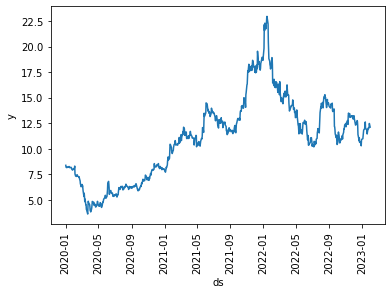

In [ ]:
#stock = yf.Ticker("C")
#stock = yf.Ticker("NFLX")
stock = yf.Ticker("F")
startd = "2020-01-01"
endd = "2023-01-31"
tests = 60

hist = stock.history(start=startd, end=endd)
hist = hist.reset_index()
hist.rename(columns={"Date": "ds", "Close": "y"}, inplace=True)
hist.head()
plt.xticks(rotation=90)
sns.lineplot(x=hist.ds, y=hist["y"])

##### Make Prophet Model 

We'll just split the dataframe as a whole, since Prophet expects the dataframe format. It knows what it is doing with each column due to the naming standard for "ds" and "y", the additional regressors are specified as we add them. Just as with a normal dataset for a regression model, adding regressors basically just adds more X columns to the feature set. 

Initial log joint probability = -9.67367
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1744.16    0.00514176        420.41      0.8179      0.8179      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1758.81    0.00129442       121.467      0.9687      0.9687      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     224        1759.8   0.000114125       88.1193    4.64e-07       0.001      304  LS failed, Hessian reset 
     245        1760.5    0.00102078       113.982   1.347e-05       0.001      363  LS failed, Hessian reset 
     299       1761.28    0.00021816       66.4637           1           1      427   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     320       1762.15    0.00136456       315.975   7.087e-06       0.001      485  LS failed, Hessian rese

0.0953691843931631

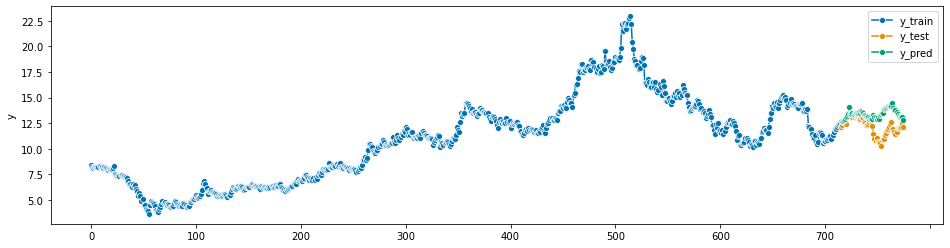

In [ ]:
# Convert index to pd.DatetimeIndex
train, test = temporal_train_test_split(hist, test_size=tests)

stockP = fbProphet(daily_seasonality=True)
#stockP.add_regressor('Open')

stockP.add_country_holidays(country_name="US")
#stockP.add_seasonality(name="weekly", fourier_order=10, period=4)


stockP.add_regressor("Volume")
stockP.add_regressor("Dividends")
stockP.add_regressor("Stock Splits")

stockP.fit(train)
preds = stockP.predict(test)
preds.index = test.index
#preds

plot_series(train["y"], test["y"], preds["yhat"], labels=["y_train", "y_test", "y_pred"])
mean_squared_percentage_error(preds["yhat"], test["y"])

We can also extract the components of the time series model, and plot them individually.

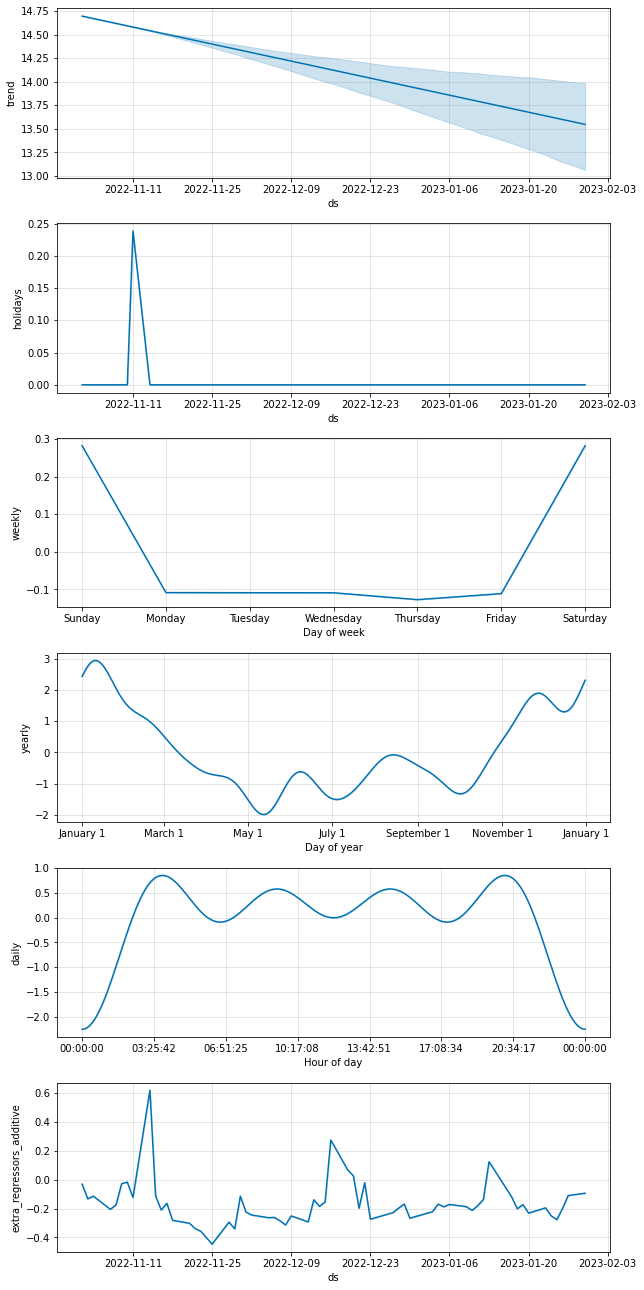

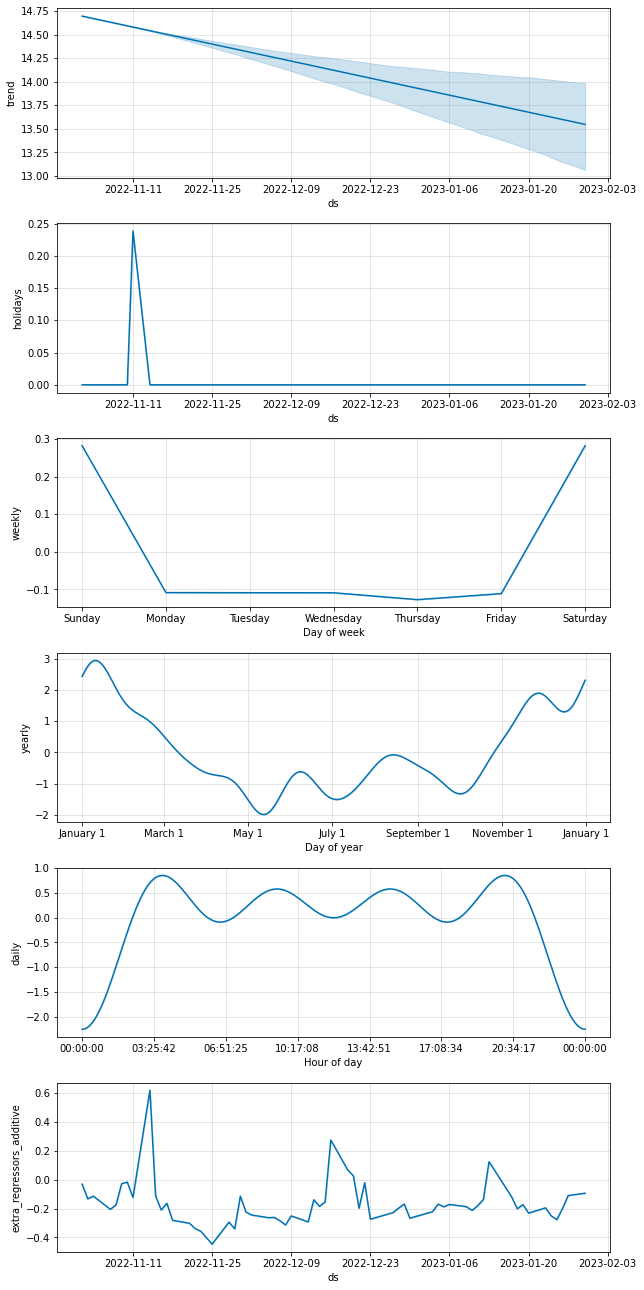

In [ ]:
stockP.plot_components(preds)

### Future and Regressors

We can also use the Prophet model to plot projections into the future. One key factor that will impact us here is that <b>we don't have the future data for the regressors that we've added to the model</b>. To build forecasts looking out into the future, we need those values. This is one common limitation of adding regressors to a time series model. We can take one of, or a combination of, a couple of approaches:
<ul>
<li> Construct a forecast for the regressors, and use that to predict the future regressor values. This could be a Prophet model, exponential smoothing, or something else. 
<li> Recreate regressors to be a function of time, and use that to predict the future regressor values.
<li> Carry on the last known value of the regressor.
<li> Build only regressors that are backwards looking, such as the average of the last 5 days instead of the current value. 
</ul>

Obviously this requires some knowledge of the data and the problem, without those we are definitely going to be introducing some substantial uncertainty into our model. What these regressors are and how they are generated will have a distinct impact on the projections that we make. Creating a prediction for a feature to a predictive model is similar in spirit to what we did in imputation, but this tends to be much more substantial. 

#### Regressor Free Model and Sesaonality Proejctions

We'll make a regressor-free example here, and generate some forecasts. We'll also add in seasonality. For seasonality we need to specify a few things - the name and period just define the period of the seasonality. The Fourier order is the number of terms in the Fourier series that we use to model the seasonality, which is beyond our scope to care about in detail. It is a parameter that we can tune, the larger the value, the more quickly the seasonality can change. Larger values are also more prone to overfitting, as they are increasing the complexity of the model. 

In [ ]:

stock2 = fbProphet(daily_seasonality=True)
stock2.add_country_holidays(country_name="US")
stock2.add_seasonality(name="weekly", fourier_order=10, period=4)
stock2.fit(hist)

INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.


Initial log joint probability = -10.5261
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


      99        1852.2     0.0170779       2314.58      0.8668      0.8668      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1877.4   0.000670095       395.817      0.3028      0.3028      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1883.29    0.00293683       337.005           1           1      358   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1889.68   0.000668775       108.146           1           1      477   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        1897.3    0.00307161       138.418      0.4457           1      586   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       1900.34   0.000542609       109.983           1           1      709   
    Iter      log 

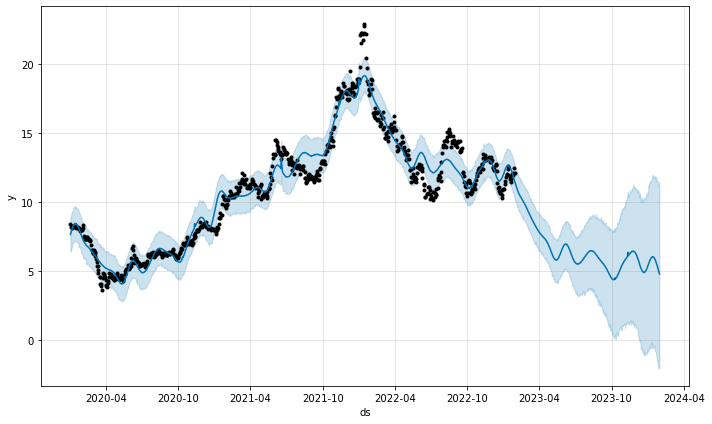

In [ ]:
future = stock2.make_future_dataframe(periods=365)
forecast = stock2.predict(future)
fig = stock2.plot(forecast)

We can also extract the parts of the time series. 

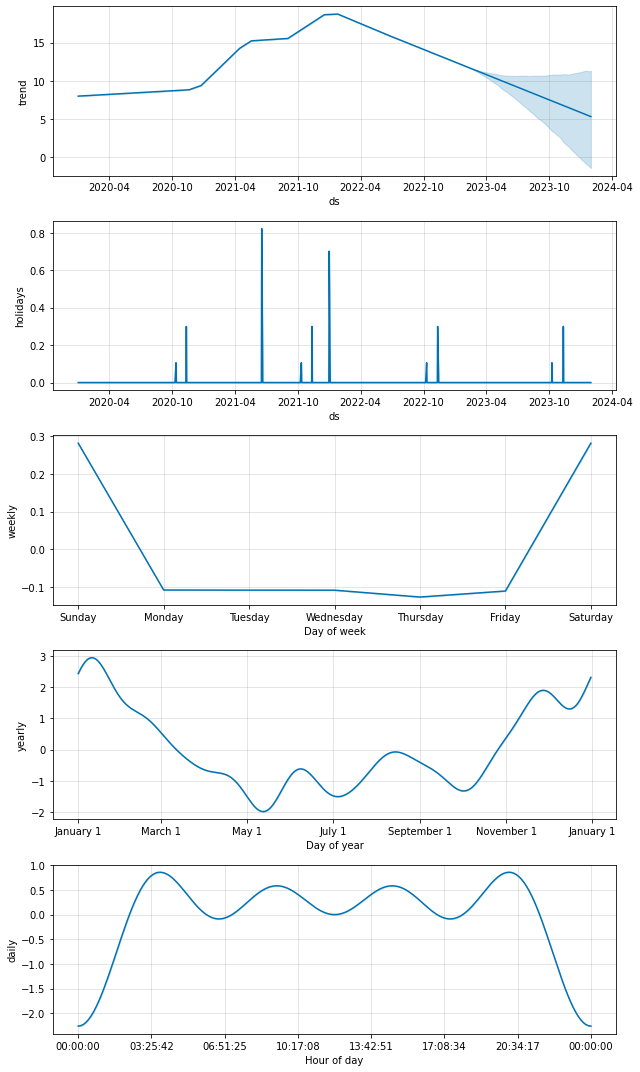

In [ ]:
fig2 = stockP.plot_components(forecast)

#### Cross-Validation in Prophet

We can use a built in cross-validation method in Prophet to test the model as well. For this we'll jump back to the model with regressors. 

<b>Note:</b> beacuse we are doing cross validation here, I'm going to refit the model with all the data, no train-test split. This is optional, but I think it makes sense here.

In [ ]:
from prophet.diagnostics import cross_validation
stockP = fbProphet(daily_seasonality=True)

stockP.add_country_holidays(country_name="US")
stockP.add_regressor("Volume")
stockP.add_regressor("Dividends")
stockP.add_regressor("Stock Splits")
stockP.fit(hist)

df_cv = cross_validation(stockP, initial='366 days', period='180 days', horizon = '30 days')
df_cv.head()

INFO:prophet:Making 5 forecasts with cutoffs between 2021-01-10 00:00:00 and 2022-12-31 00:00:00


Initial log joint probability = -10.5261
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1871.79     0.0228574       319.948           1           1      111   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1898.27    0.00211441       252.344           1           1      224   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     271        1903.4   0.000415696       112.269   4.201e-06       0.001      357  LS failed, Hessian reset 
     299       1905.17    0.00396257       130.198           1           1      393   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     325       1907.55   0.000365347       301.434   2.341e-06       0.001      468  LS failed, Hessian reset 
     399       1915.64    0.00191122        78.136           1           1      554   
    Iter      log pro

  0%|          | 0/5 [00:00<?, ?it/s]

Initial log joint probability = -11.203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       840.032   0.000710784       104.509      0.8797      0.8797      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        840.88   2.19837e-06       95.1672      0.3823      0.3823      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     234       840.949   0.000152043        133.66   1.086e-06       0.001      321  LS failed, Hessian reset 
     290       840.964     1.753e-08       93.4845      0.4998      0.4998      397   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


 20%|██        | 1/5 [00:01<00:06,  1.71s/it]

Initial log joint probability = -11.4925
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1121.91   0.000641406       107.177           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1152.43     0.0296115       506.765      0.3949           1      224   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     219       1153.76   0.000207065       195.306   2.258e-06       0.001      292  LS failed, Hessian reset 
     299          1163    0.00137024       206.294           1           1      390   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1172.03     0.0103051       139.097           1           1      502   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     432       1174.42   0.000433594    

 40%|████      | 2/5 [00:04<00:06,  2.22s/it]

Initial log joint probability = -18.0479
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1482.53     0.0202937       775.323           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1538.75     0.0090437        382.66           1           1      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1565.9    0.00918417       507.628      0.9653      0.9653      344   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1591.83     0.0164218       482.444           1           1      462   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1607.38    0.00426214       294.878           1           1      573   
    Iter      log prob        ||dx||      ||grad||       alpha  

 60%|██████    | 3/5 [00:06<00:04,  2.34s/it]

Initial log joint probability = -11.7728
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1638.8     0.0116351       687.961      0.2669      0.2669      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1682.25     0.0271813       813.421           1           1      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1704.79     0.0184876       795.904           1           1      343   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1717.75    0.00497522       1102.34           1           1      463   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1722.35    0.00830482       246.517           1           1      585   
    Iter      log prob        ||dx||      ||grad||       alpha  

 80%|████████  | 4/5 [00:09<00:02,  2.36s/it]

Initial log joint probability = -12.2594
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1831.16    0.00104045       164.592           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     187       1855.11   0.000177936       194.273    5.32e-07       0.001      273  LS failed, Hessian reset 
     199       1857.79     0.0042067       588.771           1           1      287   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1863.65    0.00100801       95.7619           1           1      408   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1864.67    0.00264543       71.5429           1           1      526   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1866.46    0.00441495    

100%|██████████| 5/5 [00:11<00:00,  2.29s/it]


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2021-01-11,8.110934,7.858138,8.365162,8.429819,2021-01-10
1,2021-01-12,8.220608,7.977749,8.471361,8.864904,2021-01-10
2,2021-01-13,8.081136,7.821892,8.350412,8.864904,2021-01-10
3,2021-01-14,8.137415,7.878047,8.382340,9.218415,2021-01-10
4,2021-01-15,8.069369,7.825205,8.323565,8.910228,2021-01-10


And we can also ask for a more simple summary of the cross validation table above. One thing to note here is that our error metrics will likely ramp up, potentially pretty drastically, as we move farther into the future. We can also expect some shocks, as there are likey times where the swings in the real data are out of pattern, so our error might skyrocket or plummet somewhat randomly. 

In [ ]:
# Python
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,1.369822,1.170394,0.863553,0.063489,0.065758,0.063886,0.400000
1,4 days,1.266540,1.125406,0.927739,0.081626,0.067140,0.081006,0.366667
2,5 days,1.239774,1.113452,1.000092,0.087560,0.075006,0.086493,0.200000
3,6 days,1.406779,1.186077,1.112418,0.087485,0.082927,0.086264,0.075000
4,7 days,1.510723,1.229115,1.167248,0.083287,0.071699,0.082094,0.100000


<AxesSubplot:xlabel='horizon', ylabel='mape'>

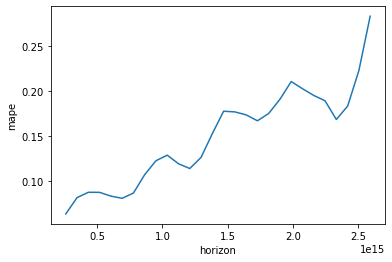

In [ ]:
sns.lineplot(data=df_p, x="horizon", y="mape")

And we can plot it as well. 

/Users/akeems/opt/anaconda3/envs/ml3950/lib/python3.9/site-packages/prophet/plot.py:539: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
/Users/akeems/opt/anaconda3/envs/ml3950/lib/python3.9/site-packages/prophet/plot.py:540: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])


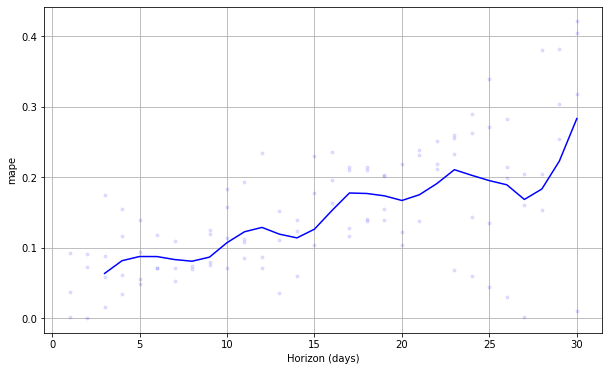

In [ ]:
# Python
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')

### Results

Maybe ok, maybe not. One thing to think of in time series data is the lag between when things happen. For example, dividends and stock splits both tend to increase the price of a stock, however that increase happens after the event is announced, not when it actually happens. If you've ever heard the term "priced in", that is what is they are refering to, the price has altered to reflect the event. In this case, we might want to transform the data for splits and dividends to be a "days since" value, so that the model can learn that the price will increase in the future. Will this work? Maybe, we are basically attempting to construct something that models real stock prices, which are complex. We don't have a definitive answer on what to do with the data, it is a trial and error process. 

Prophet also has a lot more options and features that you can explore if needed. In particular, it has a lot of options that are likely to be relevant for businesses, like the ability to custom define holidays and points in time where change can be expected, such as a new product launch, a large sale, or an explosion in news. All of these things can be constructed into other models, but Prophet makes stuff like that easy. 

## Time Series Wrap Up

Time series forecasting is a complex topic, and we've only scratched the surface. We've covered some of the basics of making forecasts, but there are more options and techniques out there. In particular, the construction of the datasets is both critical and flexible, and generally depends on domain knowledge. How we construct the data, and what we understand it to represent, will have a large impact on the results. For example, a stock price can be a price that we are predicting, as we did above; a stock price could also be the end result of a series of increases/decreases, if we were to construct a model that predicts the daily delta. For the stock example here, we could do something like transform the "Volume" feature into something like "Yesterday's Volume", or "Moving Avg of Recent Volume", so it can be used as a regressor that we'd know ahead of time. Is this a good idea? We have no clue, people making models like this to predict stock performance get paid a lot of money to figure out ways to manipulate data and create custom models that are a couple of fractions of a percent more accurate than what currently exists. As well, forecasting multiple time periods into the future is inherently more difficult and open ended, because all of our inputs have to come from the past. Even something like time of day has a lot of complexity - do we care about the specific minute, the hour, morning/afternoon/evening, etc? We need to build an understanding of the scenario to reasonably construct models to forecast it. Time series forecasting requires a somewhat different, and I'd argue more extensive, approach to preparing a dataset that captures the variance that we are trying to predict. 

All in all, we can build upon what's here to approach time series challenges, but we probably shouldn't assume that any of the above approaches will be a perfect fit for real life problems. We'd want to expand on the tools here if we are going to dig more into forecasting. In particular, there are families of neural network models that are well suited to sequential data like these time series, such as recurrent neural networks and in the past few years, transformers. These models have undergone rapid recent improvements as applications like language generation and translation are laregly a sequential problem. 